In [132]:
import networkx as nx
import matplotlib.pyplot as plt
# -*- coding: utf-8 -*-
import os
import re
from html.parser import HTMLParser
from bs4 import BeautifulSoup
from bs4 import element
from itertools import product
import numpy as np
import pandas as pd
from abbreviations import schwartz_hearst
import subprocess
from fuzzywuzzy import fuzz

In [171]:
discard_list=['funding',
              'Conflicts of Interest',
              'Additional Information',
              'Acknowledgment',
              'Acknowledgement',
              'financial',
              'contribution',
              'conflict',
              'footnotes',
              'interest',
              'Reference',
              'Formats',
              'Share',
              'Patent',
              'disclosure',
              'Availability',
              'additional',
             'supporting information',
             'notes',
             'abbreviation']


In [172]:
#discard_list=['share',"format"]
def extract_all_h2_headings(heading_text_list,heading_text_dict_with_filename,soup_og,file_name):
    headings = soup_og.find_all('h2')
    tmp_list = []
    for number, heading in enumerate(headings):
        heading_text =  heading.get_text()
        text = ''.join([i.lower() for i in heading_text if not i.isdigit()]).strip('.').strip(' ').strip(':').strip(' ').replace('\n',' ')
        if not any(word.lower() in text.lower() for word in discard_list):
            tmp_list.append(text)
    heading_text_dict_with_filename.update({file_name:tmp_list})
    return

base_dir = '/rdsgpfs/general/user/yh4218/home/data/Journal of Proteome Research (Journal)/'
#base_dir = '/rdsgpfs/general/user/yh4218/home/data/NLP/NLP-MWAS'
file_list = []
def get_files(base_dir,file_list):
    files = os.listdir(base_dir)
    for i in files:
        abs_path = os.path.join(base_dir,i)
        if re.match(r'(.*)PMC(.*).html',abs_path) and ('highlighted' not in abs_path):
            file_list.append(abs_path)
        elif os.path.isdir(abs_path)&('ipynb_checkpoints' not in abs_path):
            get_files(abs_path,file_list)
    return file_list

file_list = []
file_list = get_files(base_dir,file_list)

heading_text_list=[]
heading_text_dict_with_filename={}
#file_list=['/rdsgpfs/general/user/yh4218/home/data/Journal of Proteome Research (Journal)/PMC5035700.html']
for file in file_list:
    #output_file.write(file+'\n')
    with open(file,'r',encoding='UTF-8',errors='ignore') as f:
        text = f.read()
        soup = BeautifulSoup(text, 'html.parser')
        extract_all_h2_headings(heading_text_list,heading_text_dict_with_filename,soup,file.split('/')[-1].strip('.html'))

# Building node & edge list

In [173]:
basic_node_list=[]
basic_edge_list=[]
basic_edge_list_with_duplicates=[]
basic_edge_list_with_filename=[]
for key,value in heading_text_dict_with_filename.items():
    for e in range(len(value)):
        if e == 0:
            if value[e] not in basic_node_list:basic_node_list.append(value[e])
        else:
            if value[e] not in basic_node_list:basic_node_list.append(value[e])
            if (value[e-1],value[e]) not in basic_edge_list:
                basic_edge_list.append((value[e-1],value[e]))
            basic_edge_list_with_duplicates.append((value[e-1],value[e]))
            basic_edge_list_with_filename.append(key)

basic_edge_dict_with_counts={}
for e in basic_edge_list_with_duplicates:
    count=basic_edge_list_with_duplicates.count(e)
    basic_edge_dict_with_counts.update({e:count}) 

In [174]:
basic_edge_dict_with_filename=dict(zip(basic_edge_list_with_duplicates,basic_edge_list_with_filename))
basic_edge_dict_with_counts

def mergeDict(dict1, dict2):
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        if key in dict1 and key in dict2:
            dict3[key] = [value , dict1[key]]
    return dict3
 
# Merge dictionaries and add values of common keys in a list
basic_edge_dict_with_counts_filename = mergeDict(basic_edge_dict_with_counts,basic_edge_dict_with_filename)


# Get sum of starting node

In [175]:
starting_node_list=[]
number_list=[]
sum_dict={}
for key,value in basic_edge_dict_with_counts_filename.items():
    starting_node_list.append(key[0])
    number_list.append(value[1])
for i,element in enumerate(starting_node_list):
    list_of_index=[]
    for i2,element2 in enumerate(starting_node_list):
        if element == element2:
            list_of_index.append(i2)
    sum_dict.update({element:sum(number_list[i3] for i3 in list_of_index)})

# Calculate weights

In [176]:
basic_edge_dict_with_weights_filename={}
for key,value in basic_edge_dict_with_counts_filename.items():
    starting_node=key[0]
    basic_edge_dict_with_weights_filename.update({key:(value[0],value[1]/sum_dict[starting_node])})
basic_edge_dict_with_weights_filename

{('associated data', 'abstract'): ('PMC4729298', 1.0),
 ('abstract', 'graphical abstract'): ('PMC4849136', 0.21428571428571427),
 ('graphical abstract', 'introduction'): ('PMC4849136', 1.0),
 ('introduction', 'experimental section'): ('PMC2765409', 0.14285714285714285),
 ('experimental section', 'results'): ('PMC5035700', 0.5),
 ('results', 'discussion'): ('PMC4729298', 1.0),
 ('discussion', 'conclusion'): ('PMC5660916', 0.2222222222222222),
 ('conclusion', 'supplementary material'): ('PMC2941198', 1.0),
 ('abstract', 'introduction'): ('PMC4729298', 0.7857142857142857),
 ('introduction', 'materials and methods'): ('PMC4729298', 0.7142857142857143),
 ('materials and methods', 'results'): ('PMC4729298', 0.7),
 ('materials and methods', 'results and discussion'): ('PMC6572761', 0.3),
 ('results and discussion', 'performance comparison'): ('PMC2941198', 0.25),
 ('performance comparison', 'conclusion'): ('PMC2941198', 1.0),
 ('introduction', 'experemintal section'): ('PMC4286171', 0.0714285

# Screen by weights  / output basic_edge_dict_with_weights_filename_screened

In [177]:
discard_node_list=[]
basic_edge_dict_with_weights_filename_screened={}
for key,value in basic_edge_dict_with_weights_filename.items():
    if value[1]<0.1:
        discard_node_list.append(key[1])
discard_node_list
for discard_node in discard_node_list:
    basic_node_list.remove(discard_node)
for key,value in basic_edge_dict_with_weights_filename.items():
    if key[0] in discard_node_list or key[1] in discard_node_list:
        continue
    else:
        basic_edge_dict_with_weights_filename_screened.update({key:value})

In [178]:
basic_edge_dict_with_weights_filename_screened

{('associated data', 'abstract'): ('PMC4729298', 1.0),
 ('abstract', 'graphical abstract'): ('PMC4849136', 0.21428571428571427),
 ('graphical abstract', 'introduction'): ('PMC4849136', 1.0),
 ('introduction', 'experimental section'): ('PMC2765409', 0.14285714285714285),
 ('experimental section', 'results'): ('PMC5035700', 0.5),
 ('results', 'discussion'): ('PMC4729298', 1.0),
 ('discussion', 'conclusion'): ('PMC5660916', 0.2222222222222222),
 ('conclusion', 'supplementary material'): ('PMC2941198', 1.0),
 ('abstract', 'introduction'): ('PMC4729298', 0.7857142857142857),
 ('introduction', 'materials and methods'): ('PMC4729298', 0.7142857142857143),
 ('materials and methods', 'results'): ('PMC4729298', 0.7),
 ('materials and methods', 'results and discussion'): ('PMC6572761', 0.3),
 ('results and discussion', 'performance comparison'): ('PMC2941198', 0.25),
 ('performance comparison', 'conclusion'): ('PMC2941198', 1.0),
 ('discussion', 'conclusions'): ('PMC4849136', 0.3333333333333333),

# Draw

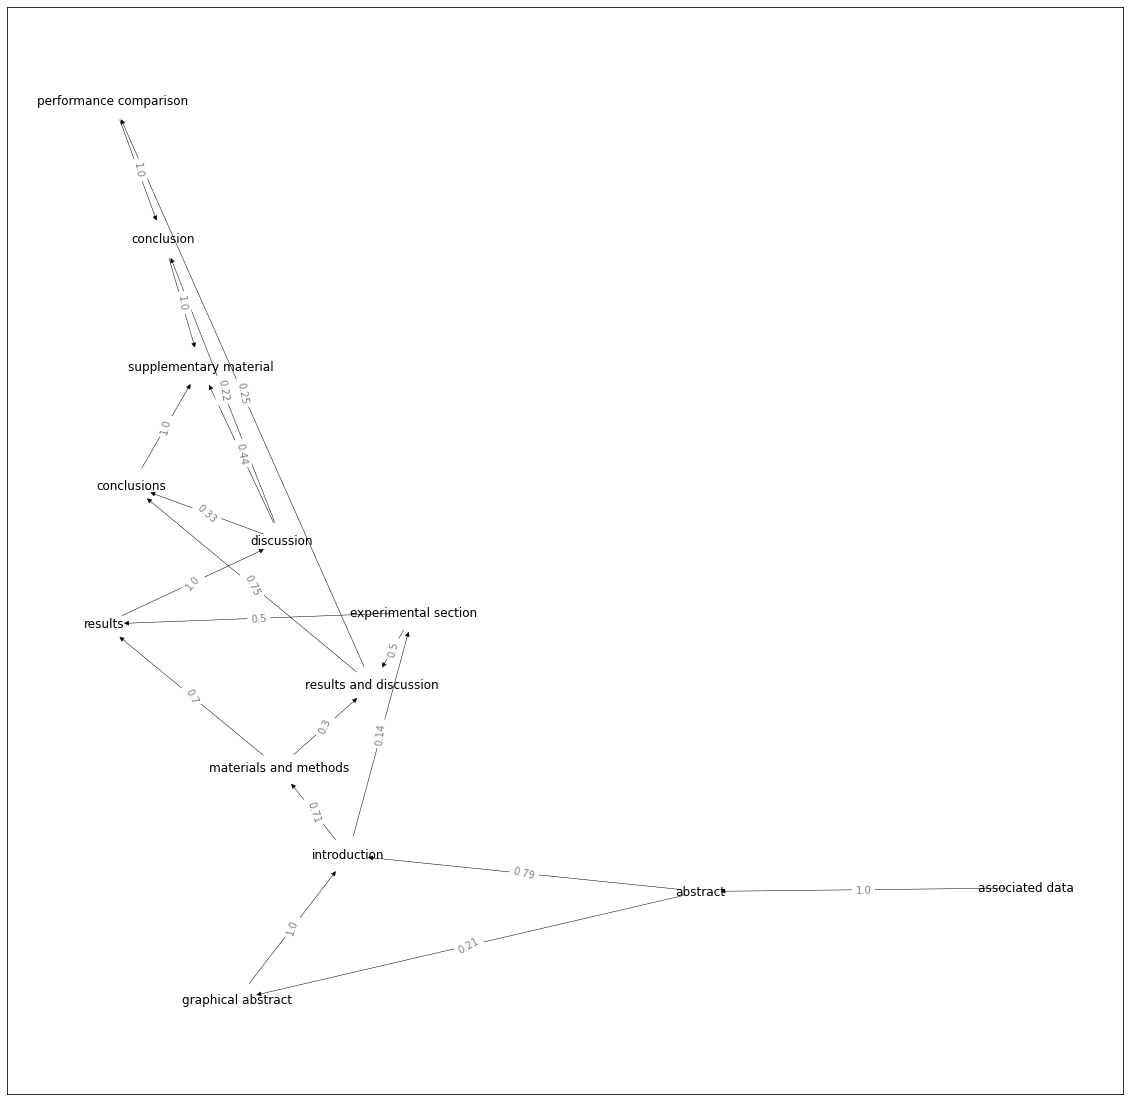

In [179]:
try:
    G.clear()
except:
    skip
plt.rcParams['figure.figsize'] = [20, 20]

G = nx.DiGraph()
#nodes
G.add_nodes_from(basic_node_list)

#edges
G.add_edges_from([edges for edges, weights in basic_edge_dict_with_weights_filename_screened.items()])

#label for nodes
labels_nodes={}
for heading in basic_node_list:
    labels_nodes[heading]=heading
    
#label for edges
labels_edges={}
for key,value in basic_edge_dict_with_weights_filename_screened.items():
    #labels_edges[key]=str(value[0])+','+str(round(value[1],2))
    labels_edges[key]=str(round(value[1],2))
    
#position
pos=nx.spring_layout(G,pos=initial_position, fixed=common_nodes)
# draw
nx.draw_networkx_edge_labels(G,pos,labels_edges,alpha=0.5)
nx.draw_networkx_nodes(G,pos,alpha=0,node_shape ='s')
nx.draw_networkx_labels(G,pos)
nx.draw_networkx_edges(G,pos,width=0.5,min_source_margin=20,min_target_margin =20)

# Complete Script

In [119]:
base_dir = '/rdsgpfs/general/user/yh4218/home/data/NLP/NLP-MWAS/Journal of Chromatography A (Journal)'

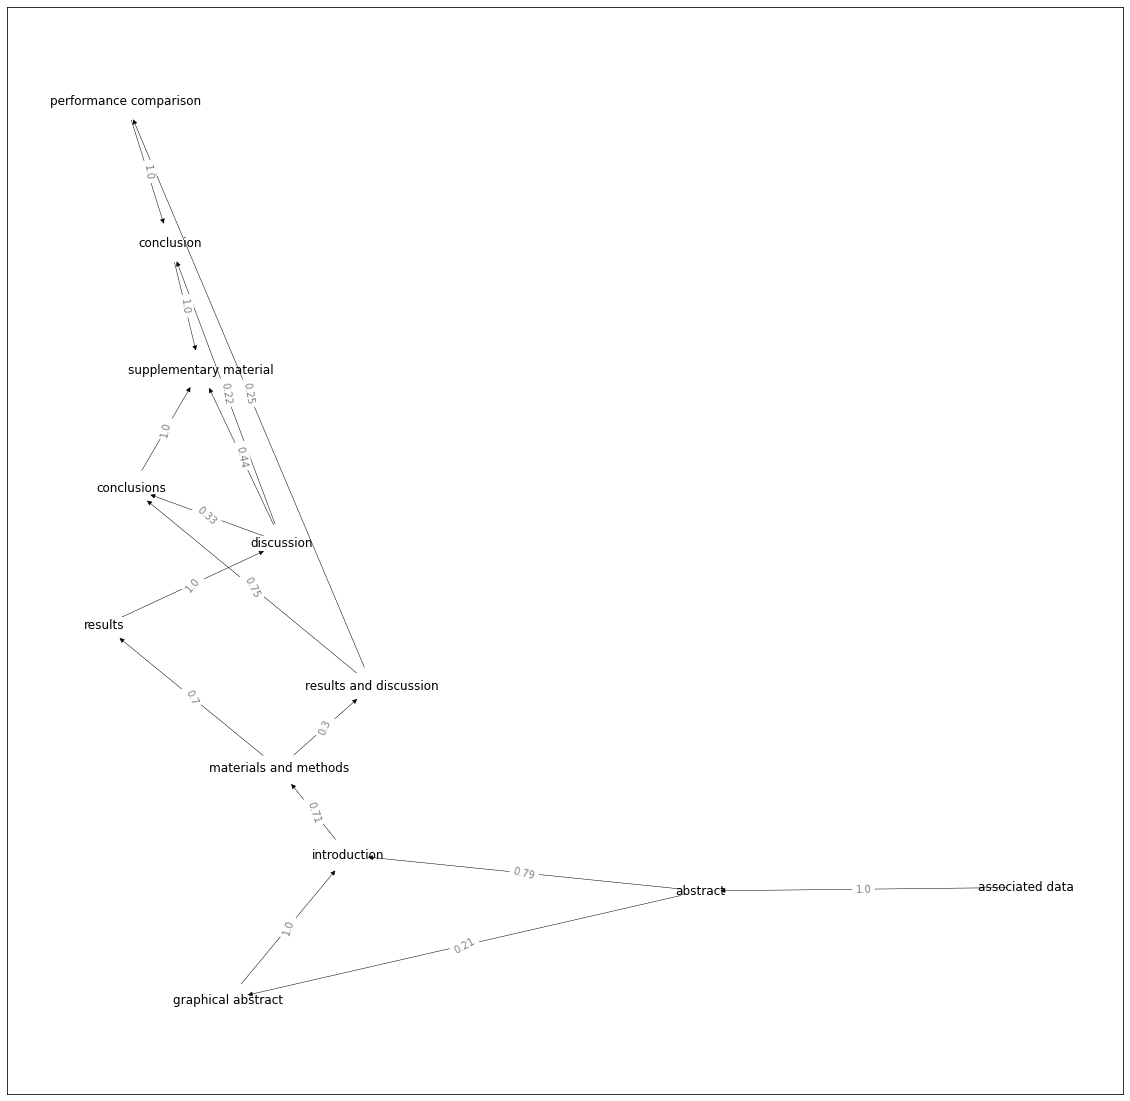

In [168]:
file_list = []
file_list = get_files(base_dir,file_list)
heading_text_list=[]
heading_text_dict_with_filename={}
for file in file_list:
    with open(file,'r',encoding='UTF-8',errors='ignore') as f:
        text = f.read()
        soup = BeautifulSoup(text, 'html.parser')
        extract_all_h2_headings(heading_text_list,heading_text_dict_with_filename,soup,file.split('/')[-1].strip('.html'))
basic_node_list2=[]
basic_edge_list=[]
basic_edge_list_with_duplicates=[]
basic_edge_list_with_filename=[]
for key,value in heading_text_dict_with_filename.items():
    for e in range(len(value)):
        if e == 0:
            if value[e] not in basic_node_list2:basic_node_list2.append(value[e])
        else:
            if value[e] not in basic_node_list2:basic_node_list2.append(value[e])
            if (value[e-1],value[e]) not in basic_edge_list:
                basic_edge_list.append((value[e-1],value[e]))
            basic_edge_list_with_duplicates.append((value[e-1],value[e]))
            basic_edge_list_with_filename.append(key)
basic_edge_dict_with_counts={}
for e in basic_edge_list_with_duplicates:
    count=basic_edge_list_with_duplicates.count(e)
    basic_edge_dict_with_counts.update({e:count})    
basic_edge_dict_with_filename=dict(zip(basic_edge_list_with_duplicates,basic_edge_list_with_filename))
basic_edge_dict_with_counts_filename = mergeDict(basic_edge_dict_with_counts,basic_edge_dict_with_filename)
starting_node_list=[]
number_list=[]
sum_dict={}
for key,value in basic_edge_dict_with_counts_filename.items():
    starting_node_list.append(key[0])
    number_list.append(value[1])
for i,element in enumerate(starting_node_list):
    list_of_index=[]
    for i2,element2 in enumerate(starting_node_list):
        if element == element2:
            list_of_index.append(i2)
    sum_dict.update({element:sum(number_list[i3] for i3 in list_of_index)})
basic_edge_dict_with_weights_filename={}
for key,value in basic_edge_dict_with_counts_filename.items():
    starting_node=key[0]
    basic_edge_dict_with_weights_filename.update({key:(value[0],value[1]/sum_dict[starting_node])})
discard_node_list=[]
basic_edge_dict_with_weights_filename_screened={}
for key,value in basic_edge_dict_with_weights_filename.items():
    if value[1]<0.2:
        discard_node_list.append(key[1])
discard_node_list
for discard_node in discard_node_list:
    basic_node_list2.remove(discard_node)
for key,value in basic_edge_dict_with_weights_filename.items():
    if key[0] in discard_node_list or key[1] in discard_node_list:
        continue
    else:
        basic_edge_dict_with_weights_filename_screened.update({key:value})
try:
    G.clear()
except:
    skip
plt.rcParams['figure.figsize'] = [20, 20]
G = nx.DiGraph()
G.add_nodes_from(basic_node_list2)
G.add_edges_from([edges for edges, weights in basic_edge_dict_with_weights_filename_screened.items()])
labels_nodes={}
for heading in basic_node_list2:
    labels_nodes[heading]=heading
#label for edges
labels_edges={}
for key,value in basic_edge_dict_with_weights_filename_screened.items():
    #labels_edges[key]=str(value[0])+','+str(round(value[1],2))
    labels_edges[key]=str(round(value[1],2))
pos=nx.spring_layout(G,pos=initial_position, fixed=common_nodes)
#pos=nx.spring_layout(G)

nx.draw_networkx_edge_labels(G,pos,labels_edges,alpha=0.5)
nx.draw_networkx_nodes(G,pos,alpha=0,node_shape ='s')
nx.draw_networkx_labels(G,pos)
nx.draw_networkx_edges(G,pos,width=0.5,min_source_margin=20,min_target_margin =20)

# find common nodes 

In [144]:
common_nodes=list(set(basic_node_list).intersection(basic_node_list2))
common_nodes

['results and discussion',
 'conclusions',
 'results',
 'discussion',
 'associated data',
 'supplementary material',
 'introduction',
 'materials and methods',
 'abstract']

# set initial position of common nodes

In [147]:
initial_position={}
for common_node in common_nodes:
    initial_position.update({common_node:pos[common_node]})
initial_position

{'results and discussion': array([-0.04347319,  0.01637241]),
 'conclusions': array([-0.34603631,  0.63232932]),
 'results': array([-0.38072743,  0.20426563]),
 'discussion': array([-0.15681723,  0.4618143 ]),
 'associated data': array([ 0.77951223, -0.6115994 ]),
 'supplementary material': array([-0.259343,  1.      ]),
 'introduction': array([-0.07373879, -0.51100806]),
 'materials and methods': array([-0.1609287 , -0.24077821]),
 'abstract': array([ 0.36958344, -0.62280489])}

In [180]:
base_dir = '/rdsgpfs/general/user/yh4218/home/data/NLP/NLP-MWAS/Analytica Chimica Acta (Journal)'

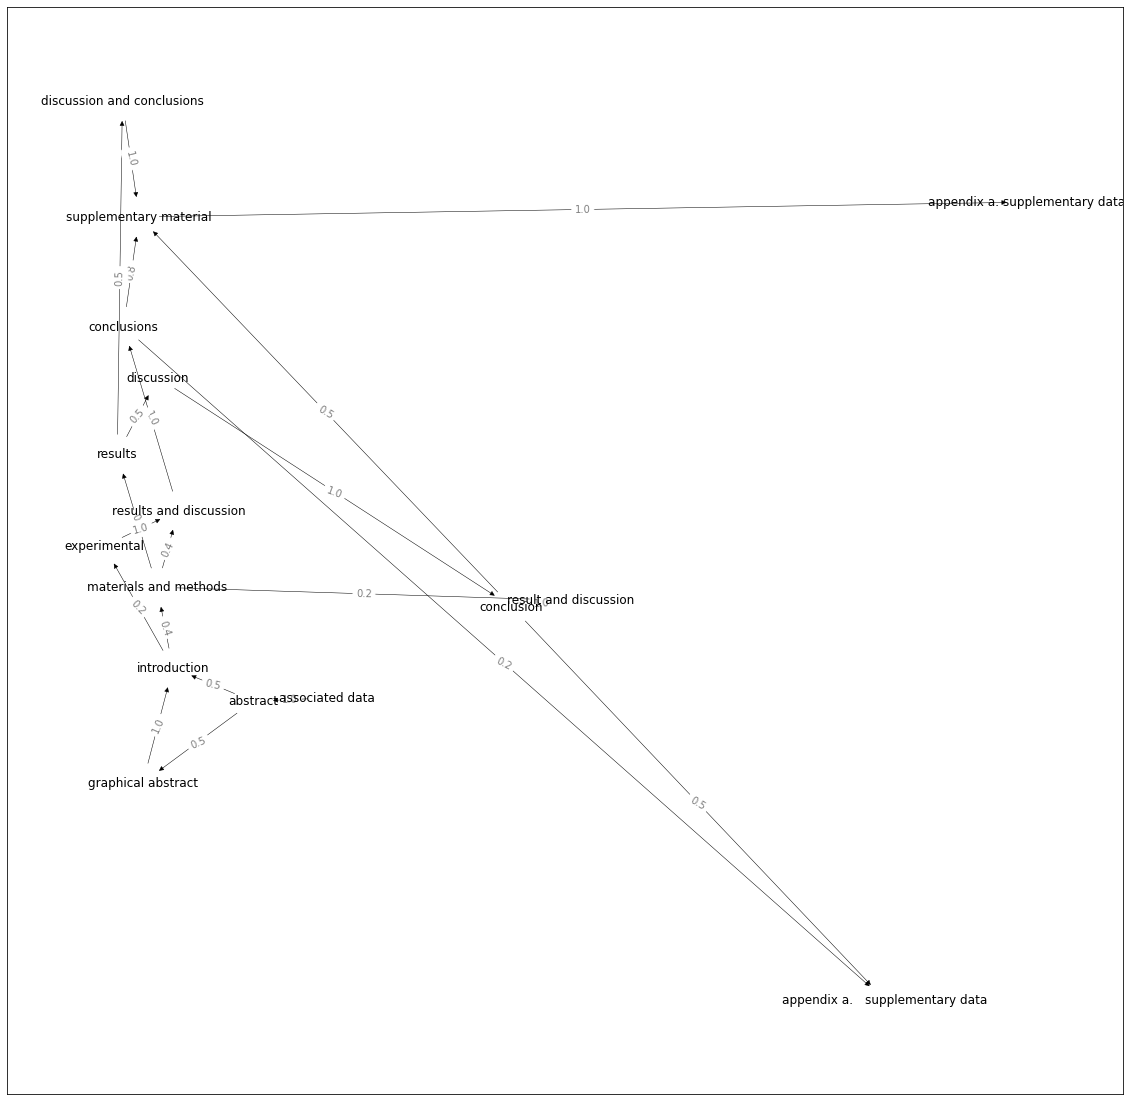

In [181]:
# test
file_list = []
file_list = get_files(base_dir,file_list)
heading_text_list=[]
heading_text_dict_with_filename={}
for file in file_list:
    with open(file,'r',encoding='UTF-8',errors='ignore') as f:
        text = f.read()
        soup = BeautifulSoup(text, 'html.parser')
        extract_all_h2_headings(heading_text_list,heading_text_dict_with_filename,soup,file.split('/')[-1].strip('.html'))
basic_node_list2=[]
basic_edge_list=[]
basic_edge_list_with_duplicates=[]
basic_edge_list_with_filename=[]
for key,value in heading_text_dict_with_filename.items():
    for e in range(len(value)):
        if e == 0:
            if value[e] not in basic_node_list2:basic_node_list2.append(value[e])
        else:
            if value[e] not in basic_node_list2:basic_node_list2.append(value[e])
            if (value[e-1],value[e]) not in basic_edge_list:
                basic_edge_list.append((value[e-1],value[e]))
            basic_edge_list_with_duplicates.append((value[e-1],value[e]))
            basic_edge_list_with_filename.append(key)
basic_edge_dict_with_counts={}
for e in basic_edge_list_with_duplicates:
    count=basic_edge_list_with_duplicates.count(e)
    basic_edge_dict_with_counts.update({e:count})    
basic_edge_dict_with_filename=dict(zip(basic_edge_list_with_duplicates,basic_edge_list_with_filename))
basic_edge_dict_with_counts_filename = mergeDict(basic_edge_dict_with_counts,basic_edge_dict_with_filename)
starting_node_list=[]
number_list=[]
sum_dict={}
for key,value in basic_edge_dict_with_counts_filename.items():
    starting_node_list.append(key[0])
    number_list.append(value[1])
for i,element in enumerate(starting_node_list):
    list_of_index=[]
    for i2,element2 in enumerate(starting_node_list):
        if element == element2:
            list_of_index.append(i2)
    sum_dict.update({element:sum(number_list[i3] for i3 in list_of_index)})
basic_edge_dict_with_weights_filename={}
for key,value in basic_edge_dict_with_counts_filename.items():
    starting_node=key[0]
    basic_edge_dict_with_weights_filename.update({key:(value[0],value[1]/sum_dict[starting_node])})
discard_node_list=[]
basic_edge_dict_with_weights_filename_screened={}
for key,value in basic_edge_dict_with_weights_filename.items():
    if value[1]<0.2:
        discard_node_list.append(key[1])
discard_node_list
for discard_node in discard_node_list:
    basic_node_list2.remove(discard_node)
for key,value in basic_edge_dict_with_weights_filename.items():
    if key[0] in discard_node_list or key[1] in discard_node_list:
        continue
    else:
        basic_edge_dict_with_weights_filename_screened.update({key:value})
try:
    G.clear()
except:
    skip
plt.rcParams['figure.figsize'] = [20, 20]
G = nx.DiGraph()
G.add_nodes_from(basic_node_list2)
G.add_edges_from([edges for edges, weights in basic_edge_dict_with_weights_filename_screened.items()])
labels_nodes={}
for heading in basic_node_list2:
    labels_nodes[heading]=heading
#label for edges
labels_edges={}
for key,value in basic_edge_dict_with_weights_filename_screened.items():
    #labels_edges[key]=str(value[0])+','+str(round(value[1],2))
    labels_edges[key]=str(round(value[1],2))
pos=nx.spring_layout(G,pos=initial_position, fixed=common_nodes)
#pos=nx.spring_layout(G)

nx.draw_networkx_edge_labels(G,pos,labels_edges,alpha=0.5)
nx.draw_networkx_nodes(G,pos,alpha=0,node_shape ='s')
nx.draw_networkx_labels(G,pos)
nx.draw_networkx_edges(G,pos,width=0.5,min_source_margin=20,min_target_margin =20)

# BACKUP!! #

[]
['associated data', 'abstract', 'introduction', 'results', 'discussion', 'materials and methods', 'conclusions', 'supplementary materials', 'methods', 'appendix a', 'lc-ms measurements', 'results and discussion', 'experimental section', 'supplementary material', 'material and methods', 'supplementary files', 'appendix a. uncertainty analysis', 'author copyright statement', 'overview', 'the application in early diagnosis of pancreatic cancer', 'the application in early diagnosis of kidney cancer', 'experimental', 'method', 'subjects and methods', 'experimental methods', 'coenzymes analysis in tissue', 'coenzymes in human whole blood', 'subcellular coenzymes']


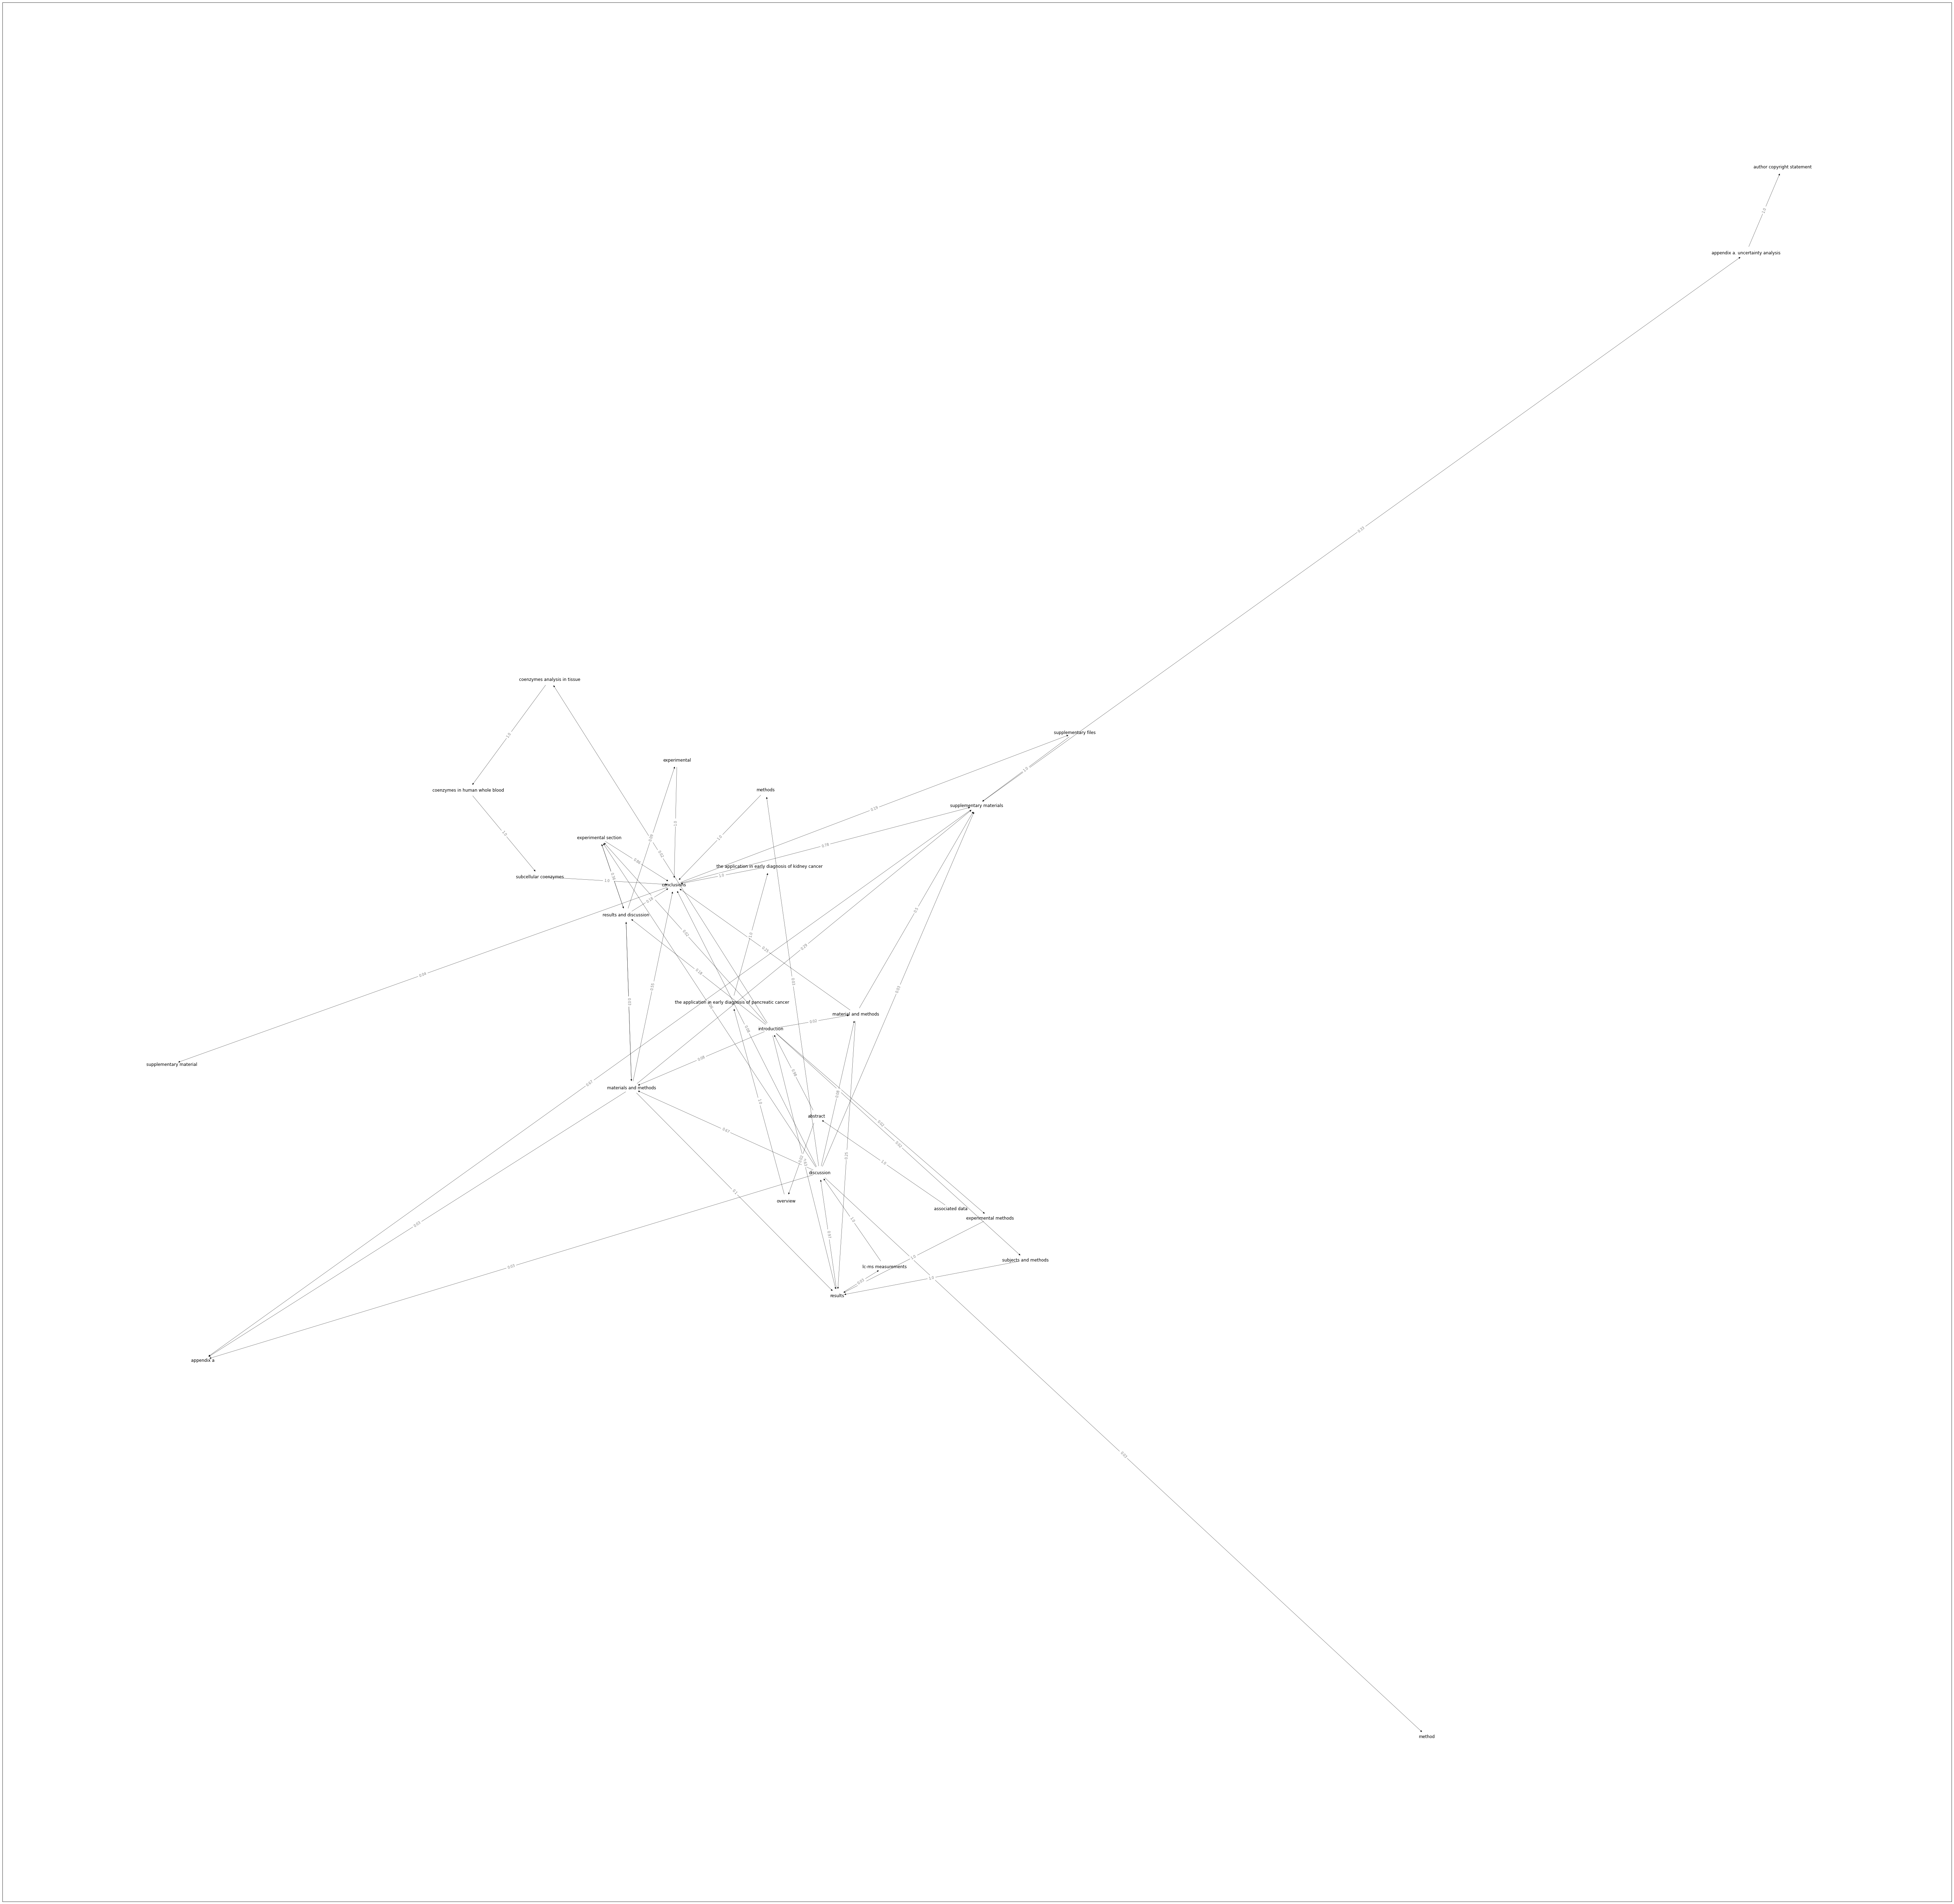

In [186]:
base_dir = '/rdsgpfs/general/user/yh4218/home/data/NLP/NLP-MWAS/Metabolites (Journal)'
file_list = []
file_list = get_files(base_dir,file_list)

heading_text_list=[]
heading_text_dict_with_filename={}
#file_list=['/rdsgpfs/general/user/yh4218/home/data/Journal of Proteome Research (Journal)/PMC5035700.html']
for file in file_list:
    #output_file.write(file+'\n')
    with open(file,'r',encoding='UTF-8',errors='ignore') as f:
        text = f.read()
        soup = BeautifulSoup(text, 'html.parser')
        extract_all_h2_headings(heading_text_list,heading_text_dict_with_filename,soup,file.split('/')[-1].strip('.html'))
        
basic_node_list=[]
basic_edge_list=[]
basic_edge_list_with_duplicates=[]
basic_edge_list_with_filename=[]
for key,value in heading_text_dict_with_filename.items():
    for e in range(len(value)):
        if e == 0:
            if value[e] not in basic_node_list:basic_node_list.append(value[e])
        else:
            if value[e] not in basic_node_list:basic_node_list.append(value[e])
            if (value[e-1],value[e]) not in basic_edge_list:
                basic_edge_list.append((value[e-1],value[e]))
            basic_edge_list_with_duplicates.append((value[e-1],value[e]))
            basic_edge_list_with_filename.append(key)

basic_edge_dict_with_counts={}
for e in basic_edge_list_with_duplicates:
    count=basic_edge_list_with_duplicates.count(e)
    basic_edge_dict_with_counts.update({e:count}) 
        
basic_edge_dict_with_filename=dict(zip(basic_edge_list_with_duplicates,basic_edge_list_with_filename))
basic_edge_dict_with_counts_filename = mergeDict(basic_edge_dict_with_counts,basic_edge_dict_with_filename)
starting_node_list=[]
number_list=[]
sum_dict={}
for key,value in basic_edge_dict_with_counts_filename.items():
    starting_node_list.append(key[0])
    number_list.append(value[1])
for i,element in enumerate(starting_node_list):
    list_of_index=[]
    for i2,element2 in enumerate(starting_node_list):
        if element == element2:
            list_of_index.append(i2)
    sum_dict.update({element:sum(number_list[i3] for i3 in list_of_index)})
    
basic_edge_dict_with_weights_filename={}
for key,value in basic_edge_dict_with_counts_filename.items():
    starting_node=key[0]
    basic_edge_dict_with_weights_filename.update({key:(value[0],value[1]/sum_dict[starting_node])})

discard_node_list=[]
basic_edge_dict_with_weights_filename_screened={}
for key,value in basic_edge_dict_with_weights_filename.items():
    if value[1]<0.01:
        discard_node_list.append(key[1])

for discard_node in discard_node_list:
    basic_node_list.remove(discard_node)
for key,value in basic_edge_dict_with_weights_filename.items():
    if key[0] in discard_node_list or key[1] in discard_node_list:
        continue
    else:
        basic_edge_dict_with_weights_filename_screened.update({key:value})

try:
    G.clear()
except:
    skip

plt.rcParams['figure.figsize'] = [100, 100]
G = nx.DiGraph()
#nodes
G.add_nodes_from(basic_node_list)

#edges
G.add_edges_from([edges for edges, weights in basic_edge_dict_with_weights_filename_screened.items()])

#label for nodes
labels_nodes={}
for heading in basic_node_list:
    labels_nodes[heading]=heading
    
#label for edges
labels_edges={}
for key,value in basic_edge_dict_with_weights_filename_screened.items():
    #labels_edges[key]=str(value[0])+','+str(round(value[1],2))
    labels_edges[key]=str(round(value[1],2))
    
#position
pos=nx.spring_layout(G)

# draw
nx.draw_networkx_edge_labels(G,pos,labels_edges,alpha=0.5)
nx.draw_networkx_nodes(G,pos,alpha=0,node_shape ='s')
nx.draw_networkx_labels(G,pos)
nx.draw_networkx_edges(G,pos,width=0.5,min_source_margin=20,min_target_margin =20)

